# NumPyの配列

標準のPythonでは、リストを使用して一連の値を保存し、配列として使用することができます。しかし、リストの要素は任意のオブジェクトであるため、リストにはオブジェクトへのポインタが保存されます。例えば`[1, 2, 3]`のような単純なリストを保存するためには、3つのポインタと3つの整数オブジェクトが必要です。数値計算において、この構造は明らかにメモリとCPUの計算時間を浪費します。

さらに、Pythonは`array`モジュールも提供しており、これが提供する`array`オブジェクトはリストとは異なり、数値を直接保存することができ、C言語の1次元配列に似ています。しかし、多次元配列をサポートしておらず、さまざまな演算関数もないため、数値計算には適していません。

NumPyの誕生はこれらの欠点を補うもので、NumPyは以下の2つの基本的なオブジェクトを提供します：

* ndarray(n-dimensional array object)：単一のデータ型を保存する多次元配列であり、後で統一して配列と呼びます。
* ufunc(universal function object)：配列を処理するための特殊な関数です。

本書ではNumPy 2.1.3を使用しています。以下のプログラムを実行して、NumPyのバージョン番号を確認してください：

In [1]:
import helper.magics
from matplotlib import pyplot as plt
import helper.matplotlib
import numpy as np

np.__version__

'2.1.3'

## リストとarray配列のメモリ構造

このセクションでは、まずNumPy配列とリスト、および`array`モジュールの配列を比較し、NumPy配列のメモリ構造を理解するのに役立ちます。

Pythonの標準データ型には配列型がありません。多次元配列を表現する必要がある場合、ネストされたリストを使用するしかありません。しかし、Pythonではすべてがオブジェクトであるため、3×3の2次元配列を表現するには、次のグラフに示すように4つのリストオブジェクトと9つの浮動小数点数オブジェクトが必要です。図中の各リストオブジェクトは固定サイズのメモリ領域であり、その`ob_item`フィールドはリスト内の各要素オブジェクトを指すポインタ配列を指しています。また、Pythonでは浮動小数点数もオブジェクトであるため、実際の数値に加えて、オブジェクトに必要な追加情報（図中のfloat header部分）も保存する必要があります。

![ネストされたリストのメモリ構造](images/nested-list.svg "")

明らかに、ネストされたリスト構造はメモリ空間を浪費するだけでなく、データがメモリ内に分散している可能性があり、キャッシュメカニズムによるメモリアクセス速度の向上には不利です。以下の`iter_all_size(obj)`は`sys.getsizeof()`を使用して、ネストされたリストが占めるメモリバイト数を計算します。

In [2]:
import sys

alist = [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]


def iter_all_size(obj):
    yield sys.getsizeof(obj)

    if isinstance(obj, list):
        for o in obj:
            yield from iter_all_size(o)


sum(iter_all_size(alist))

560

Python標準ライブラリの`array`モジュールの`array`配列を使用すると、複数の数値のバイナリデータを連続して保存することができます。`array`配列のメモリ構造は次のグラフに示す通りです。`ob_item`フィールドは配列のバイナリデータを保存するメモリ領域を指し、`ob_descr`フィールドは配列要素の型を記述するオブジェクトを指します。しかし、`array`配列は1次元のみであり、多次元配列を表現することはできません。

![array配列のメモリ構造](images/array.svg "")

In [3]:
from array import array

arr = array("d", [1, 2, 3, 4, 5, 6, 7, 8, 9])
print(f"{sys.getsizeof(arr) = }")

sys.getsizeof(arr) = 152


## NumPy配列のメモリ構造

NumPyの`ndarray`配列は、前述の`array`配列と同様に、データストレージ領域に直接配列の各要素の値を保存します。さらに、`ndarray`配列の`dtype`属性は配列要素のデータ型を保存し、`ndim`は配列の次元を保存し、`shape`は配列のサイズを保存し、`strides`は配列要素間のアドレスオフセットを保存し、`flags`は配列のさまざまなストレージフラグを保存します。以下では、ネストされたリスト`alist`を`ndarray`配列に変換し、その占めるメモリを計算します。結果から、`ndarray`はデータをより効率的に保存でき、データ量が大きいほどこの利点が顕著であることがわかります。

![NumPy配列のメモリ構造](images/ndarray.svg "")

In [4]:
from helper.numpy import array_pretty

ndarr = np.asarray(alist)
array_pretty(ndarr)
print(f"{sys.getsizeof(ndarr) = }")

float64 shape:(3, 3) strides:(24, 8) W|C|O
[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]
sys.getsizeof(ndarr) = 200


ndarray配列の`tobytes()`メソッドを使用すると、データストレージ領域の生データを取得できます。これはバイト列(bytes)オブジェクト`arr_bytes`を返します。❶は`arr_bytes`の最初の8バイトの内容を表示し、この8バイトは倍精度浮動小数点数1.0のバイナリデータです。❷はPythonの標準ライブラリの`struct`モジュールを使用してこのバイナリデータを解析することができ、"9d"はバイナリデータが9つの倍精度浮動小数点数であることを示します。

In [5]:
import struct

arr_bytes = ndarr.tobytes()
print(arr_bytes[:8].hex(" "))  #❶
struct.unpack("9d", arr_bytes)  #❷

00 00 00 00 00 00 f0 3f


(1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0)

ndarray配列は他のオブジェクトとデータストレージ領域を共有することもできます。❶は`numpy.asarray()`を使用してarray配列`arr`をndarray配列`ndarr_view1`に変換し、`asarray()`は自動的に要素型を取得できます。❷は`numpy.frombuffer()`を使用してバイト列オブジェクトとデータを共有する配列`ndarr_views2`を作成し、パラメータ`dtype`で配列の要素型を指定します。"f8"は8バイトの倍精度浮動小数点数型を示します。

プログラムでは、3つの配列の`owndata`と`writeable`フラグを確認します。`owndata`が`True`の場合、その配列はデータストレージ領域を所有しており、`False`の場合、データストレージ領域は他のオブジェクトによって提供されています。`writable`が`True`の場合、データストレージ領域は書き込み可能です。`ndarr`はネストされたリスト`alist`から変換されたものであり、ネストされたリストとメモリを共有できないため、`asarray()`はすべてのデータをコピーし、`arr`はデータストレージ領域を所有しています。`ndarr_view1`はarrayオブジェクト`arr`から変換されたものであり、`arr`とデータストレージ領域を共有しているため、`owndata`フラグは`False`です。`ndarr_view2`は`arr_bytes`とデータストレージ領域を共有しており、bytesオブジェクトは不変であるため、`ndarr_view2`の`writeable`フラグは`False`です。

In [6]:
ndarr_view1 = np.asarray(arr)  #❶
ndarr_view2 = np.frombuffer(arr_bytes, dtype="f8")  #❷
print(f"{ndarr      .flags.owndata =  }, {ndarr      .flags.writeable = }")
print(f"{ndarr_view1.flags.owndata = }, {ndarr_view1.flags.writeable = }")
print(f"{ndarr_view2.flags.owndata = }, {ndarr_view2.flags.writeable = }")

ndarr      .flags.owndata =  True, ndarr      .flags.writeable = True
ndarr_view1.flags.owndata = False, ndarr_view1.flags.writeable = True
ndarr_view2.flags.owndata = False, ndarr_view2.flags.writeable = False


他のオブジェクトとデータストレージ領域を共有する場合、参照されているオブジェクトがガベージコレクションされないようにする必要があるため、ndarray配列は`base`属性を使用して参照されているオブジェクトを保存します。次のグラフは、`ndarr_view1`と`ndarr_view2`の2つの配列と、それらが参照するオブジェクトのメモリ内の構造を示しています。

![他のオブジェクトとメモリを共有する配列](images/ndarray-view.svg "")

以下のプログラムを使用してこのグラフを検証できます：

In [7]:
ndarr_view1.base.obj is arr, ndarr_view2.base is arr_bytes

(True, True)

## shapeとstrides属性

配列の`shape`属性は配列の形状を保存し、配列の各軸の長さを記述するタプルです。配列`ndarr`の`shape`属性には2つの要素があるため、これは2次元配列であり、第0軸の長さは3、第1軸の長さも3です。配列の`strides`属性は各軸上の隣接する2つの要素のアドレス差、つまりある軸のインデックスが1増加したときに、データストレージ領域内のポインタが増加するバイト数を保存します。例えば、`ndarr`の`strides`は`(24, 8)`であり、第0軸のインデックスが1増加すると、データのアドレスは24バイト増加します。つまり、`ndarr[1, 0]`のアドレスは`ndarr[0, 0]`のアドレスより24バイト大きく、これは3つの倍精度浮動小数点数の総バイト数に相当します。第1軸のインデックスが1増加すると、データのアドレスは8バイト増加し、これは1つの倍精度浮動小数点数のバイト数に相当します。

`strides`属性の値が対応する軸が占めるバイト数と正確に一致する場合、データはメモリ内で連続して保存されます。多次元配列の要素は、データストレージ領域内で2つの形式で配置されます：C言語形式とFortran言語形式です。C言語では、多次元配列の第0軸が最上位であり、第0軸のインデックスが1増加すると、要素のアドレスが最も多く増加します。一方、Fortran言語では、多次元配列の第0軸が最下位であり、第0軸のインデックスが1増加すると、アドレスは1つの要素のバイト数だけ増加します。配列オブジェクトの`T`属性を使用すると、`strides`属性が反転された配列を取得できます。これは元の配列とデータストレージ領域を共有します。以下の例では、`ndarr`配列はデータストレージ領域を所有しており、`ndarr_t`は`ndarr`のビューであり、両者の`strides`属性は正反対です。

In [8]:
ndarr_t = ndarr.T
array_pretty(ndarr)
array_pretty(ndarr_t)

float64 shape:(3, 3) strides:(24, 8) W|C|O
[[1. 2. 3.]
 [4. 5. 6.]
 [7. 8. 9.]]
float64 shape:(3, 3) strides:(8, 24) W|F
[[1. 4. 7.]
 [2. 5. 8.]
 [3. 6. 9.]]


![配列の転置と元の配列の関係](images/ndarray-transpose.svg "")

`ndarr`の`C_CONTIGUOUS`フラグが`True`の場合、その要素はC言語形式で連続して配置されており、`ndarr_t`の`F_CONTIGUOUS`フラグが`True`の場合、その要素はFortran言語形式で連続して配置されています。

In [9]:
print(ndarr.flags["C_CONTIGUOUS"], ndarr_t.flags["F_CONTIGUOUS"])

True True


スライスを使用して同じデータブロックから異なる`shape`と`strides`の配列オブジェクトを作成するだけでなく、これらの属性を直接設定することで、スライスでは実現できない効果を得ることができます。例えば：

In [10]:
from numpy.lib.stride_tricks import as_strided

a = np.arange(6)
b = as_strided(a, shape=(4, 3), strides=(4, 4))
%C a; b

        a                               b                    
------------------  -----------------------------------------
[0, 1, 2, 3, 4, 5]  [[          0,  4294967296,           1],
                     [ 4294967296,           1,  8589934592],
                     [          1,  8589934592,           2],
                     [ 8589934592,           2, 12884901888]]


この例では、NumPyの補助モジュールから`as_strided()`関数をインポートしました。そして、長さ6の1次元配列`a`から、形状が`(4, 3)`の2次元配列`b`を作成しました。`strides`パラメータを使用して配列`b`の`strides`属性を直接指定したため、配列`b`と配列`a`はデータブロックを共有し、`b`の前後の行には2つの要素が重複しています。例えば、以下のように`a[2]`の値を変更すると、`b`の前の3行の対応する要素も変更されます：

In [11]:
a[2] = 20
b

array([[          0,  4294967296,           1],
       [ 4294967296,           1, 85899345920],
       [          1, 85899345920,          20],
       [85899345920,          20, 12884901888]])

データを処理する際、データをブロック処理する必要があり、平滑化を保つために各ブロック間に一定の重複が必要な場合があります。このような場合、上記の方法を使用してデータを重複させてブロック処理することができます。ただし、`as_strided()`を使用する際、NumPyはメモリ境界チェックを行わないため、`shape`と`strides`の設定が不適切な場合、予期しないエラーが発生する可能性があります。

## メモリビュー

`ndarray`の`view()`メソッドを使用して、同じデータブロックから異なる`dtype`の配列オブジェクトを作成することができます。つまり、同じメモリ内のバイナリデータを異なる数値型で表示することができます：

In [12]:
a = np.array([[0, 1], [2, 3], [4, 5]], dtype=np.float32)
b = a.view(np.uint32)
c = a.view(np.uint8)
%C 2 b; c

            b                                   c                     
--------------------------  ------------------------------------------
[[         0, 1065353216],  [[  0,   0,   0,   0,   0,   0, 128,  63],
 [1073741824, 1077936128],   [  0,   0,   0,  64,   0,   0,  64,  64],
 [1082130432, 1084227584]]   [  0,   0, 128,  64,   0,   0, 160,  64]]


配列`a`の要素型は単精度浮動小数点数であり、4バイトを占有します。`a.view(np.uint32)`を使用して、新しい配列を作成します。この配列は配列`a`と同じデータメモリを使用しますが、4バイトのデータを符号なし32ビット整数として処理します。一方、`a.view(np.uint8)`は各バイトを単一バイトの符号なし整数として扱うため、形状が`(3, 8)`の配列が得られます。`view()`メソッドを使用して得られた新しい配列は元の配列とメモリを共有し、`a[0, 0]`が変更されると、`b[0, 0]`と`c[0, :4]`も変更されます：

In [13]:
a[0, 0] = 3.14
%C 2 b[0, 0]; c[0, :4]

       b[0, 0]               c[0, :4]      
---------------------  --------------------
np.uint32(1078523331)  [195, 245,  72,  64]


次に、`view()`メソッドを使用した興味深い例を見てみましょう。『Quake III Arena』のC言語ソースコードには、平方根の逆数を計算する魔法のような関数`Q_rsqrt()`があります。コードではニュートン法を使用して平方根の逆数を計算していますが、これは特に魔法ではありません。しかし、その中には魔法の数字`0x5f3759df`が含まれており、単精度浮動小数点数を32ビット整数として扱い、理解しがたい演算を行っています：

:::{seealso}
https://en.wikipedia.org/wiki/Fast_inverse_square_root

ウィキペディアの『Quake』で`0x5f3759df`を使用して平方根の逆数を計算するアルゴリズムの説明
:::

```c
float Q_rsqrt( float number )
{
	long i;
	float x2, y;
	const float threehalfs = 1.5F;
 
	x2 = number * 0.5F;
	y  = number;
	i  = * ( long * ) &y;                       // 浮動小数点数のビットレベルハック
	i  = 0x5f3759df - ( i >> 1 );               // これは一体何？
	y  = * ( float * ) &i;
	y  = y * ( threehalfs - ( x2 * y * y ) );   // 最初のニュートン反復
	return y;
}
```

以下に、NumPyを使用して同じ計算を実装します：

In [14]:
number = np.linspace(0.1, 10, 100)
y = number.astype(np.float32)  #❶
x2 = y * 0.5
i = y.view(np.int32)  #❷
i[:] = 0x5F3759DF - (i >> 1)  #❸
y = y * (1.5 - x2 * y * y)  #❹
np.max(np.abs(1 / np.sqrt(number) - y))  #❺

np.float64(0.005045614041059743)

❶`linspace()`で作成された配列の型は倍精度浮動小数点数であるため、ここではまず`astype()`メソッドを使用して単精度浮動小数点数配列`y`に変換します。❷`view()`メソッドを使用して、`y`とメモリを共有する32ビット整数配列`i`を作成します。❸整数配列`i`に対して理解しがたい演算を行い、結果を配列`i`に再書き込みます。`i`と`y`はメモリを共有しているため、この時点で`y`の値も変化します。ここでの代入は`i = 0x5f3759df - (i >> 1)`のように書くことはできません。もしそう書くと、配列`i`はまったく新しい配列になってしまいます。❹ニュートン反復演算を1回行います。ここでは`y = ...`の書き方を使用しているため、`y`は新しい配列になり、元の`i`とはメモリを共有しなくなります。このコードには多くの配列演算が含まれており、これについては次の節で詳しく説明します。❺最後に、真の値と近似値の間の最大誤差を出力します。次のグラフは絶対誤差と独立変数の関係を示しており、`number`が小さいときは絶対誤差が大きくなりますが、このときの関数値も大きいため、相対誤差の変化はそれほど大きくありません。

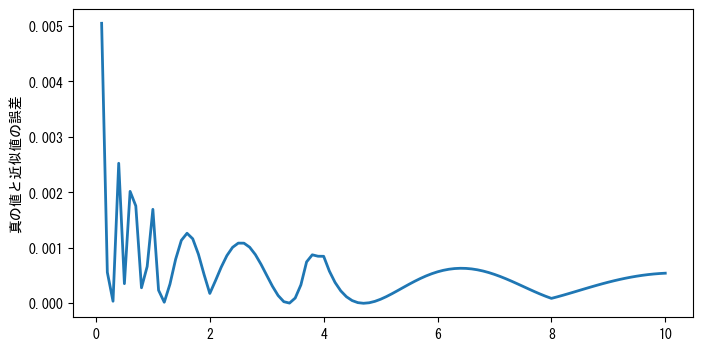

In [15]:
plt.figure(figsize=(8, 4))
plt.plot(number, 1 / np.sqrt(number) - y, lw=2)
plt.ylabel("真の値と近似値の誤差");

## 配列の作成

### 1次元配列のインデックスアクセス

1次元配列の要素にアクセスするために、単一の整数、スライスオブジェクト、整数リスト、整数配列、またはブール配列をインデックスとして使用できます。整数とスライスオブジェクトの使用方法はリストと同じです：

* `a[5]`：整数をインデックスとして使用して、配列内の特定の要素を取得します。
* `a[3:5]`：スライスをインデックスとして使用して、配列の一部を取得します。`a[3]`を含みますが、`a[5]`は含みません。
* `a[:5]`：スライスで開始インデックスを省略すると、`a[0]`から開始します。
* `a[:-1]`：インデックスに負の数を使用できます。これは配列の最後から数えることを意味します。

In [16]:
a = np.asarray([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
%C a[5]; a[3:5]; a[:5]; a[:-1]

    a[5]     a[3:5]       a[:5]                  a[:-1]          
-----------  ------  ---------------  ---------------------------
np.int64(5)  [3, 4]  [0, 1, 2, 3, 4]  [0, 1, 2, 3, 4, 5, 6, 7, 8]


* `a[1:-1:2]`：スライスの3番目のパラメータはステップを表し、2は1つおきに要素を取得することを意味します。
* `a[::-1]`：スライスの開始インデックスと終了インデックスを省略し、ステップを-1にすると、配列全体が逆順になります。
* `a[5:1:-2]`：ステップが負の数の場合、開始インデックスは終了インデックスより大きくなければなりません。

In [17]:
%C a[1:-1:2]; a[::-1]; a[5:1:-2]

 a[1:-1:2]               a[::-1]              a[5:1:-2]
------------  ------------------------------  ---------
[1, 3, 5, 7]  [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]  [5, 3]   


リストとは異なり、スライスを使用して取得した新しい配列は元の配列のビューであり、元の配列と同じデータストレージ領域を共有します。ただし、その`shape`、`strides`、`data`属性は元の配列とは異なります。次のグラフは配列`a`と`b`のメモリ内の構造を示す図です。

![配列スライスビュー](images/ndarray-slice.svg "")

In [18]:
b = a[1::2]
print(f"{b.strides=} {b.shape=} {b.base is a}")

b.strides=(16,) b.shape=(5,) True


インデックスオブジェクトが整数リストまたは配列の場合、その各要素がインデックスとして使用されます。インデックスオブジェクトがブールリストまたはブール配列の場合、`True`に対応する要素が取得されます。これらのオブジェクトをインデックスとして使用する場合、新しい配列は元の配列とデータを共有しません：

In [19]:
c = a[[1, 3, 4, 5]]
d = a[[True, False, False, True, True, False, False, True, True, True]]
print(f"{c=} {c.base=}")
print(f"{d=} {d.base=}")

c=array([1, 3, 4, 5]) c.base=None
d=array([0, 3, 4, 7, 8, 9]) d.base=None


通常、ブール演算のufunc関数を使用してブール配列を生成します。ufunc関数については次のセクションで説明します。以下に、ブール配列インデックスの使用法を示す簡単な例を示します：

In [20]:
x = np.random.randint(0, 10, 6)  # 長さ6で、要素値が0から9のランダムな整数配列を生成
%C x; x > 5

        x                             x > 5                   
------------------  ------------------------------------------
[3, 6, 2, 4, 1, 6]  [False,  True, False, False, False,  True]


式`x > 5`は、配列`x`の各要素を5と比較し、ブール配列を取得します。`True`は`x`の対応する値が5より大きいことを示します。`x > 5`で得られたブール配列を使用して、`x`内の5より大きいすべての値を収集できます：

In [21]:
x[x > 5]

array([6, 6], dtype=int32)

### 多次元配列のインデックスアクセス

多次元配列のアクセスは1次元配列と似ていますが、多次元配列には複数の軸があるため、そのインデックスは複数の値で表す必要があります。NumPyはタプルを配列のインデックスとして使用し、タプルの各要素は配列の各軸に対応します。次のグラフは形状が(6, 6)の配列aを示しており、図中に各インデックスに対応する選択領域が示されています。図中のインデックスはすべて2つの要素を持つタプルであり、その第0要素は配列の第0軸（縦軸）に対応し、第1要素は配列の第1軸（横軸）に対応します。

![多次元配列のスライスインデックス](images/ndarray-multindex.svg "")

:::{admonition} なぜタプルを添字として使用するのか
:class: note
Pythonの添字構文（`[]`を使用してシーケンス内の要素にアクセスする）自体は多次元をサポートしていませんが、任意のオブジェクトを添字として使用できるため、NumPyはタプルを添字として使用して配列内の要素にアクセスします。タプルを使用すると、複数の軸の添字を簡単に表現できます。Pythonプログラムでは、タプルの要素を丸括弧で囲むことがよくありますが、実際にはタプルの構文では要素をカンマで区切るだけで十分です。例えば、`x, y = y, x`はタプルを使用して変数の値を交換する例です。したがって、`a[1, 2]`と`a[(1, 2)]`は完全に同じで、どちらもタプル`(1,2)`を配列`a`の添字として使用しています。
:::

In [22]:
a = np.arange(0, 60, 10)[:, None] + np.arange(0, 6)
%C a[0, 3:5]; a[4:, 4:]; a[:, 2]; a[2::2, ::2]

a[0, 3:5]  a[4:, 4:]           a[:, 2]            a[2::2, ::2] 
---------  ----------  ------------------------  --------------
[3, 4]     [[44, 45],  [ 2, 12, 22, 32, 42, 52]  [[20, 22, 24],
            [54, 55]]                             [40, 42, 44]]


添字タプルに整数とスライスのみが含まれている場合、得られる配列は元の配列とデータを共有し、元の配列のビューとなります：

In [23]:
b = a[0, 3:5]
b.base is a

True

配列の添字はタプルであるため、添字タプルを保存し、同じタプルを使用して複数の配列にアクセスできます。以下の例では、`a[idx]`と`a[::2, 2:]`は同じです。

In [24]:
idx = slice(None, None, 2), slice(2, None)
a[idx]

array([[ 2,  3,  4,  5],
       [22, 23, 24, 25],
       [42, 43, 44, 45]])

組み込み関数`slice()`を使用して添字を作成するのは面倒なので、NumPyは`s_`オブジェクトを提供して、配列の添字を作成するのを助けます。`s_`に多次元配列の添字を使用すると、その添字を表すタプルが得られます：

In [25]:
np.s_[::2, 2:]

(slice(None, None, 2), slice(2, None, None))

多次元配列の添字タプルでは、整数タプルやリスト、整数配列、ブール配列も使用できます。図2-2に示すように、これらのオブジェクトを添字として使用すると、得られるデータは元のデータのコピーとなるため、結果の配列を変更しても元の配列は変更されません。

![整数配列とブール配列を使用して多次元配列の要素にアクセスする](images/ndarray-multindex2.svg "")

以下の式では、添字は2つの要素を持つタプルで、タプルの各要素は整数リストであり、それぞれ配列の第0軸と第1軸に対応しています。2つのシーケンスの対応する位置から2つの整数を取り出して添字を構成し、結果として`a[0, 1]`、`a[1, 2]`、`a[2, 3]`、`a[3, 4]`が得られます。

In [26]:
a[[0, 1, 2, 3], [1, 2, 3, 4]]

array([ 1, 12, 23, 34])

以下の式では、第0軸の添字はスライスオブジェクトで、3行目以降のすべての行を選択します。第1軸の添字は整数リストで、0、2、5列を選択します。

In [27]:
a[3:, [0, 2, 5]]

array([[30, 32, 35],
       [40, 42, 45],
       [50, 52, 55]])

以下の式では、第0軸の添字はブール配列で、0、2、5行を選択します。第1軸の添字は整数で、2列を選択します。

In [28]:
mask = np.array([1, 0, 1, 0, 0, 1], dtype=bool)
a[mask, 2]

array([ 2, 22, 52])

すべての軸で同じ形状の整数配列を添字として使用すると、得られる配列は添字配列と同じ形状になり、以下のプログラムと同じ効果があります：

```python
a[[0, 1, 2, 3], [-1, -2, -3, -4]].reshape(2, 2)
```

In [29]:
x = np.array([[0, 1], [2, 3]])
y = np.array([[-1, -2], [-3, -4]])
a[x, y]

array([[ 5, 14],
       [23, 32]])

第1軸の添字が指定されていない場合、`:`を添字として使用するため、3次元配列が得られます：

In [30]:
a[x]

array([[[ 0,  1,  2,  3,  4,  5],
        [10, 11, 12, 13, 14, 15]],

       [[20, 21, 22, 23, 24, 25],
        [30, 31, 32, 33, 34, 35]]])

このように整数配列を添字として使用して、配列内の各要素を迅速に置き換えることができます。例えば、インデックス画像を表す配列`image`と、パレット配列`palette`がある場合、`palette[image]`を使用してパレットで着色されたカラー画像を得ることができます：

In [31]:
palette = np.array([[0, 0, 0], [255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 255, 255]])
image = np.array([[0, 1, 2, 0], [0, 3, 4, 0]])
palette[image]

array([[[  0,   0,   0],
        [255,   0,   0],
        [  0, 255,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0, 255],
        [255, 255, 255],
        [  0,   0,   0]]])